In [ ]:
# Install necessary libraries
!pip install transformers
!pip install emoji
!pip install wordsegment
!pip install sentencepiece

In [ ]:
# Import necesarry libraries
import random as python_random
import argparse
import numpy as np

from keras.initializers import Constant
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelBinarizer

from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer

import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import Callback

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import emoji
from wordsegment import load, segment

In [ ]:
# Mounting google drive to import files later
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Setting random seeds
np.random.seed(123)
tf.random.set_seed(123)
python_random.seed(123)

In [ ]:
def create_arg_parser():
    """Function that builds up all the arguments used in this script.
    :return: the parsed arguments
    """
    drive_path = "/content/gdrive/MyDrive/lfd_fp_data/" # File path in drive, can be removed when using as a solo python script.
    parser = argparse.ArgumentParser()

    parser.add_argument('-f') # needed to run in google colab, can be removed outside colab.
    parser.add_argument("-i",
                        "--train_file",
                        default=drive_path + 'train.tsv',
                        type=str,
                        help="Input file to learn from (default train.tsv)"
    )
    parser.add_argument("-d",
                        "--dev_file",
                        type=str,
                        default=drive_path + 'dev.tsv',
                        help="Separate dev set to read in (default dev.tsv)"
    )
    parser.add_argument("-t",
                        "--test_file",
                        type=str,
                        default=drive_path + 'test.tsv',
                        help="If added, use trained model to predict on test set"
    )

    args = parser.parse_args()

    return args

In [ ]:
def read_corpus(corpus_file, demojize_clean=False, wordsegment=False):
    """
    Reads the corpus file and gets the documents with labels.
    :param str corpus_file: Path to the corpus file.
    :return: the document
    :return: the labels
    """
    documents = []
    labels = []

    with open(corpus_file, encoding="utf-8") as in_file:
        for line in in_file:
            if args.demojize:
                line = emoji.demojize(line)

            elif args.demojize_clean:
                line = emoji.demojize(line)
                for word in line.split():
                    if word[0] == ":" and word[-1] == ":":
                        line = line.replace(word, " ".join(segment(word)))

            if args.wordsegment:
                for word in line.split():
                    if "#" in word:
                        line = line.replace(word, " ".join(segment(word)))


            documents.append(' '.join(line.split()[:-1]))
            labels.append(line.split()[-1])

    return documents, labels

In [ ]:
class F1ScoreCallback(Callback):
    def __init__(self, X_dev, Y_dev_bin):
        self.X_dev = X_dev
        self.Y_dev_bin = Y_dev_bin

    def on_epoch_end(self, epoch, logs=None):
        Y_pred_dev = self.model.predict(self.X_dev)["logits"]
        f1 = f1_score(self.Y_dev_bin, (Y_pred_dev > 0.5).astype(int), average="macro")
        print(f"Epoch {epoch + 1} - F1 Score on Dev Set: {f1:.4f}")

In [ ]:
def create_model(X_train, X_dev, Y_train_bin, Y_dev_bin, X_test, Y_test_bin):
  '''Create and train the LM'''

  # A different LM can be specified here
  lm = 'bert-base-uncased'

  tokenizer = AutoTokenizer.from_pretrained(lm)

  model = TFAutoModelForSequenceClassification.from_pretrained(lm, num_labels=2)

  tokens_train = tokenizer(X_train, padding=True, max_length=100, truncation=True, return_tensors="np").data
  tokens_dev = tokenizer(X_dev, padding=True, max_length=100, truncation=True, return_tensors="np").data
  tokens_test = tokenizer(X_test, padding=True, max_length=100, truncation=True, return_tensors="np").data

  loss_function = BinaryCrossentropy(from_logits=True)

  optim = Adam(learning_rate=5e-5)

  model.compile(loss=loss_function, optimizer=optim, metrics=["accuracy"])

  f1_callback = F1ScoreCallback(tokens_dev, Y_dev_bin)

  model.fit(tokens_train, Y_train_bin, verbose=1, epochs=2, batch_size=32, validation_data=(tokens_dev, Y_dev_bin), callbacks=[f1_callback])

  Y_pred = model.predict(tokens_test)["logits"]


  return Y_pred

In [ ]:
args = create_arg_parser()

# Read in the data and embeddings
X_train, Y_train = read_corpus(args.train_file, demojize_clean=True, wordsegment=True)
X_dev, Y_dev = read_corpus(args.dev_file, demojize_clean=True, wordsegment=True)
X_test, Y_test = read_corpus(args.test_file, demojize_clean=True, wordsegment=True)

# Transform string labels to one-hot encodings
encoder = LabelBinarizer()

Y_train_bin = encoder.fit_transform(Y_train)
Y_train_bin = np.hstack((Y_train_bin, 1 - Y_train_bin))

Y_dev_bin = encoder.fit_transform(Y_dev)
Y_dev_bin = np.hstack((Y_dev_bin, 1 - Y_dev_bin))

Y_test_bin = encoder.fit_transform(Y_test)
Y_test_bin = np.hstack((Y_test_bin, 1 - Y_test_bin))

predictions = create_model(X_train, X_dev, Y_train_bin, Y_dev_bin, X_test, Y_test_bin)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
32/32 [==============================] - 10s 217ms/step
Epoch 1 - F1 Score on Dev Set: 0.7299
383/383 [==============================] - 325s 698ms/step - loss: 0.4794 - accuracy: 0.7772 - val_loss: 0.4375 - val_accuracy: 0.7910
Epoch 2/2
32/32 [==============================] - 7s 221ms/step
Epoch 2 - F1 Score on Dev Set: 0.7388
27/27 [==============================] - 9s 217ms/step


Accuracy score for test set: 0.8511627906976744
f1 score for test set macro: 0.8021624108580631


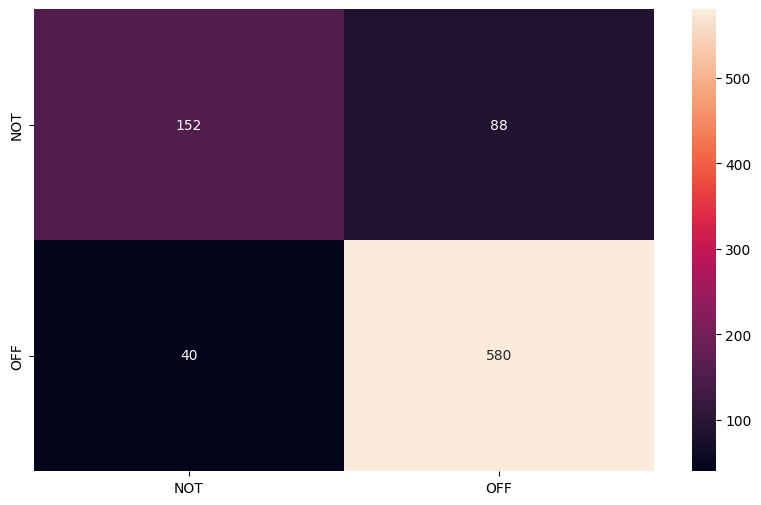

In [ ]:
# This is where the test-set scores are calculated as well as
# it creates the confusion matrix for the test set

true_labels = []
for i in Y_test_bin:

  true_labels.append(np.where(i==1)[0][0])

true_preds = []
for p in predictions:
  x = np.argmax(p)

  true_preds.append(x)

print("Accuracy score for test set: {}".format(accuracy_score(true_labels, true_preds)))
print("f1 score for test set macro: {}".format(f1_score(true_labels, true_preds, average='macro')))

# Printing confusion matrix
cf_matrix = confusion_matrix(true_labels, true_preds)
index = ["NOT", "OFF"]
columns  = ["NOT", "OFF"]
cm_df = pd.DataFrame(cf_matrix,columns,index)

fig = plt.figure(figsize=(10,6))
sns.heatmap(cm_df, annot=True, fmt='g')

fig.savefig('matrix_bert_run_withpre')